# Use duckdb python api

In this notebook, we will use duckdb python api to explore some functionality of the duck db. 

In [23]:
import pandas as pd
import geopandas as gpd
import duckdb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Matplotlib is building the font cache; this may take a moment.


In [2]:
root_dir = "/home/pengfei/data_set/demo_chu"
csv_file_path = f"{root_dir}/pathologies.csv"
parquet_file_path = f"{root_dir}/pathologies.parquet"

In [3]:
! ls -lah /home/pengfei/data_set/demo_chu

total 709M
drwxrwxr-x  4 pengfei pengfei 4.0K May 22 17:05 .
drwxrwxr-x 13 pengfei pengfei 4.0K May 22 12:03 ..
drwxrwxr-x  2 pengfei pengfei 4.0K May 22 15:46 demo_base
drwxrwxr-x  2 pengfei pengfei 4.0K May 22 16:39 gadm41_FRA
-rw-rw-r--  1 pengfei pengfei 657M May 16 15:54 pathologies.csv
-rw-rw-r--  1 pengfei pengfei  26M May 22 17:05 pathologies.parquet
-rw-rw-r--  1 pengfei pengfei  26M May 17 09:03 pathologies.parquet.bkp


## Create a duckdb instance

As we mentioned in the introduction, duckdb has two modes:
- in-memory: duckdb.connect()
- on-disk: duckdb.connect("path/to/file")

In [9]:
## Create an in-memory duckdb instance 
# conn = duckdb.connect()

# create an on disk instance, you can also activate the read only option
conn = duckdb.connect("/home/pengfei/data_set/demo_chu/demo_base/py_mydb.db")

## 1. Compare the data loading speed 

In this section, we compare the data loading speed between duck db and pandas

### 1.1 Compare the reading speed of  csv


In [10]:
%%time
# read csv
csv_query = f"""create or replace view patho_csv as select * from read_csv('{csv_file_path}', header=true, delim = ';'); select count(*) from patho_csv"""

# this will return a pandas dataframe
csv_row_count = conn.execute(csv_query).df()

print(type(csv_row_count))
csv_row_count.head(5)

<class 'pandas.core.frame.DataFrame'>
CPU times: user 1.67 s, sys: 794 ms, total: 2.46 s
Wall time: 1.9 s


,count_star()
0,4057201


> we can notice the execution time of count row number action takes about 1.5 seconds

Now let's try to read the csv with pandas


In [11]:
%%time
csv_pdf = pd.read_csv(csv_file_path, sep=";")

print(f"row count: {len(csv_pdf)}")

<timed exec>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.


row count: 4057201
CPU times: user 8.41 s, sys: 1.3 s, total: 9.71 s
Wall time: 10.5 s


In [7]:
row_number, col_number = csv_pdf.shape
print(f"The data set contains {row_number} rows and {col_number} columns")

The data set contains 4057201 rows and 16 columns


> we can notice the execution time for pandas is about 11 seconds. so we gain about 7 times the execution time

### 1.2 Compare the reading speed of parquet


In [12]:
%%time
# read parquet with duck db
parquet_query = f"""create or replace view patho_parquet as select * from read_parquet('{parquet_file_path}'); select count(*) from patho_parquet"""

# this will return a pandas dataframe
parquet_row_count = conn.execute(parquet_query).df()

parquet_row_count.head(5)

CPU times: user 11.2 ms, sys: 5.58 ms, total: 16.7 ms
Wall time: 17.4 ms


,count_star()
0,4057201


> With parquet and duckdb, we can reduce the data loading time to 4 ms

In [13]:
%%time
# read parquet with pandas

parquet_pdf = pd.read_parquet(parquet_file_path, engine='pyarrow')
print(f"row count: {len(parquet_pdf)}")

row count: 4057201
CPU times: user 1.98 s, sys: 873 ms, total: 2.85 s
Wall time: 1.48 s


> pandas can't read parquet natively, it requires pyarrow or fastparquet, here we use the pyarrow package. But still duckdb wins on the count operation

## 2. Compare the different action times

### 2.1 Get the table schema

In [13]:
%%time
table_name = "patho_csv"
query2 = f"Describe {table_name}"
schema = conn.execute(query2).df()
schema.head(15)

CPU times: user 0 ns, sys: 1.73 ms, total: 1.73 ms
Wall time: 1.37 ms


,column_name,column_type,null,key,default,extra
0,annee,BIGINT,YES,None,None,None
1,patho_niv1,VARCHAR,YES,None,None,None
2,patho_niv2,VARCHAR,YES,None,None,None
3,patho_niv3,VARCHAR,YES,None,None,None
4,top,VARCHAR,YES,None,None,None
5,cla_age_5,VARCHAR,YES,None,None,None
6,sexe,BIGINT,YES,None,None,None
7,region,VARCHAR,YES,None,None,None
8,dept,VARCHAR,YES,None,None,None
9,ntop,BIGINT,YES,None,None,None


In [14]:
%%time
print(csv_pdf.dtypes)

annee                 float64
patho_niv1             object
patho_niv2             object
patho_niv3             object
top                    object
cla_age_5              object
sexe                  float64
region                  int64
dept                   object
ntop                  float64
npop                  float64
prev                  float64
niveau_prioritaire     object
libelle_classe_age     object
libelle_sexe           object
tri                   float64
dtype: object
CPU times: user 958 µs, sys: 0 ns, total: 958 µs
Wall time: 950 µs


> This time the winner is pyarrow/pandas

### 2.2 Test Filter query speed


In [24]:
%%time
parquet_filter_query = f"select annee, sexe, dept from patho_parquet where (sexe = 9.0) AND (dept = '75')"

parquet_filter_res = conn.execute(parquet_filter_query).df()

parquet_filter_res.head()

CPU times: user 139 ms, sys: 15.9 ms, total: 155 ms
Wall time: 150 ms


,annee,sexe,dept
0,2017.0,9.0,75
1,2017.0,9.0,75
2,2017.0,9.0,75
3,2017.0,9.0,75
4,2017.0,9.0,75


In [34]:
%%time
csv_filter_query = f"select annee, sexe, dept from patho_csv where (sexe = 9.0) AND (dept = '75')"

csv_filter_res = conn.execute(csv_filter_query).df()

csv_filter_res.head()

CPU times: user 3.47 s, sys: 594 ms, total: 4.06 s
Wall time: 2.12 s


,annee,sexe,dept
0,2017,9,75
1,2017,9,75
2,2017,9,75
3,2017,9,75
4,2017,9,75


In [32]:
%%time

parquet_filter_pdf = parquet_pdf[(parquet_pdf['sexe']==9.0) & (parquet_pdf['dept']=='75')][['annee','sexe','dept']]
parquet_filter_pdf.head()

CPU times: user 330 ms, sys: 4.47 ms, total: 334 ms
Wall time: 348 ms


,annee,sexe,dept
110,2017.0,9.0,75
364,2017.0,9.0,75
733,2017.0,9.0,75
1087,2017.0,9.0,75
1351,2017.0,9.0,75


In [36]:
%%time

csv_filter_pdf = csv_pdf[(csv_pdf['sexe']==9.0) & (csv_pdf['dept']=='75')][['annee','sexe','dept']]
csv_filter_pdf.head()

CPU times: user 330 ms, sys: 6.45 ms, total: 337 ms
Wall time: 341 ms


,annee,sexe,dept
110,2017.0,9.0,75
364,2017.0,9.0,75
733,2017.0,9.0,75
1087,2017.0,9.0,75
1351,2017.0,9.0,75


> We can notice that pandas wins on csv dataframe, but duckdb wins on the parquet dataframe. That's because pandas loads all data **into the memory in a column oriented format**. DuckDB does lazy loading on the persist tables.

### 2.3 Test group by query speed

In [41]:
%%time
parquet_gb_query = f"SELECT dept, sexe, annee, patho_niv1, SUM(ntop), AVG(npop) FROM patho_parquet GROUP BY ALL;"

parquet_gb_res = conn.execute(parquet_gb_query).df()

parquet_gb_res.head()

CPU times: user 1.13 s, sys: 90.8 ms, total: 1.22 s
Wall time: 636 ms


,dept,sexe,annee,patho_niv1,sum(ntop),avg(npop)
0,999,9.0,2017.0,"Pas de pathologies repérées, traitements, mate...",141214160.0,650668.847118
1,12,9.0,2017.0,"Pas de pathologies repérées, traitements, mate...",275540.0,25562.380952
2,74,9.0,2017.0,"Pas de pathologies repérées, traitements, mate...",927010.0,72589.523810
3,13,9.0,2017.0,"Pas de pathologies repérées, traitements, mate...",2192800.0,195884.285714
4,75,1.0,2017.0,"Pas de pathologies repérées, traitements, mate...",1210060.0,93000.000000


In [40]:
%%time
csv_gb_query = f"SELECT dept, sexe, annee, patho_niv1, SUM(ntop), AVG(npop) FROM patho_csv GROUP BY ALL;"

csv_gb_res = conn.execute(csv_gb_query).df()

csv_gb_res.head()

CPU times: user 2.83 s, sys: 918 ms, total: 3.75 s
Wall time: 1.96 s


,dept,sexe,annee,patho_niv1,sum(ntop),avg(npop)
0,974,9.0,2015.0,"Pas de pathologies repérées, traitements, mate...",1003380.0,81860.476190
1,08,1.0,2017.0,Traitements psychotropes (hors pathologies),49260.0,12117.142857
2,976,9.0,2015.0,"Pas de pathologies repérées, traitements, mate...",138000.0,8770.476190
3,94,9.0,2015.0,"Pas de pathologies repérées, traitements, mate...",1517450.0,124338.095238
4,28,9.0,2015.0,"Pas de pathologies repérées, traitements, mate...",448080.0,39621.904762


In [65]:
%%time
grouped = parquet_pdf.groupby(['dept', 'sexe', 'annee', 'patho_niv1']).agg({
    'ntop': 'sum',
    'npop': 'sum'
}).reset_index()

grouped.head()

CPU times: user 709 ms, sys: 80.6 ms, total: 790 ms
Wall time: 1.45 s


,dept,sexe,annee,patho_niv1,ntop,npop
0,01,1.0,2015.0,Autres affections de longue durée (dont 31 et 32),11440.0,551530.0
1,01,1.0,2015.0,Cancers,83490.0,7169890.0
2,01,1.0,2015.0,Diabète,31030.0,551530.0
3,01,1.0,2015.0,Hospitalisations ponctuelles (avec ou sans pat...,79760.0,551530.0
4,01,1.0,2015.0,Insuffisance rénale chronique terminale,1460.0,2206120.0


> Duckdb and parquet wins 

## 3. Interoperability 

### 3.1 Create a dataframe with duckdb for cancer analysis

In [14]:
cancer_query = (f"""
        SELECT patho_niv1, dept as departement, SUM(ntop) as malades, SUM(npop) as pop
        FROM patho_parquet
        WHERE annee = 2018.0
        GROUP BY patho_niv1, dept;
    """)

cancer_res = conn.execute(cancer_query).df()

cancer_res.head()

,patho_niv1,departement,malades,pop
0,Hospitalisations ponctuelles (avec ou sans pat...,72,360930.0,2205190.0
1,Hospitalisations ponctuelles (avec ou sans pat...,40,262790.0,1656080.0
2,Hospitalisations ponctuelles (avec ou sans pat...,30,455640.0,2992640.0
3,Hospitalisations ponctuelles (avec ou sans pat...,82,165440.0,1033720.0
4,Hospitalisations ponctuelles (avec ou sans pat...,09,95180.0,596130.0


In [15]:
cancer_res.insert(1, 'perc', cancer_res['malades']/cancer_res['pop'] * 100)

cancer_res.head(5)

,patho_niv1,perc,departement,malades,pop
0,Hospitalisations ponctuelles (avec ou sans pat...,16.367297,72,360930.0,2205190.0
1,Hospitalisations ponctuelles (avec ou sans pat...,15.868195,40,262790.0,1656080.0
2,Hospitalisations ponctuelles (avec ou sans pat...,15.225353,30,455640.0,2992640.0
3,Hospitalisations ponctuelles (avec ou sans pat...,16.004334,82,165440.0,1033720.0
4,Hospitalisations ponctuelles (avec ou sans pat...,15.966316,09,95180.0,596130.0


In [17]:
cancer_res.sort_values(by="perc", ascending=True).head(100)

,patho_niv1,perc,departement,malades,pop
37,Insuffisance rénale chronique terminale,0.042143,90,920.0,2183040.0
945,Insuffisance rénale chronique terminale,0.043069,48,490.0,1137720.0
936,Insuffisance rénale chronique terminale,0.047345,05,1040.0,2196640.0
942,Insuffisance rénale chronique terminale,0.049071,79,2860.0,5828320.0
1398,Insuffisance rénale chronique terminale,0.051388,2A,1140.0,2218400.0
...,...,...,...,...,...
26,Insuffisance rénale chronique terminale,0.079298,94,16980.0,21413000.0
1402,Insuffisance rénale chronique terminale,0.079759,67,14040.0,17603080.0
38,Insuffisance rénale chronique terminale,0.080232,52,2160.0,2692200.0
483,Insuffisance rénale chronique terminale,0.084821,57,12320.0,14524680.0


## 3.2 Read shape file and build geo pandas dataframe

In [21]:
gadm_path = f"{root_dir}/gadm41_FRA/gadm41_FRA_2.shp"
gdf = gpd.read_file(gadm_path)
gdf['code'] = gdf['CC_2'].astype(str).str.zfill(2)

In [19]:
disease_to_plot = 'Cancers'
cancer_res_filtered = cancer_res[cancer_res['patho_niv1'] == disease_to_plot]

In [22]:
# Joindre les données géographiques avec les données de patients
merged = gdf.set_index('code').join(cancer_res_filtered.set_index('departement'))
print(merged.columns)

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry', 'patho_niv1', 'perc', 'malades', 'pop'],
      dtype='object')


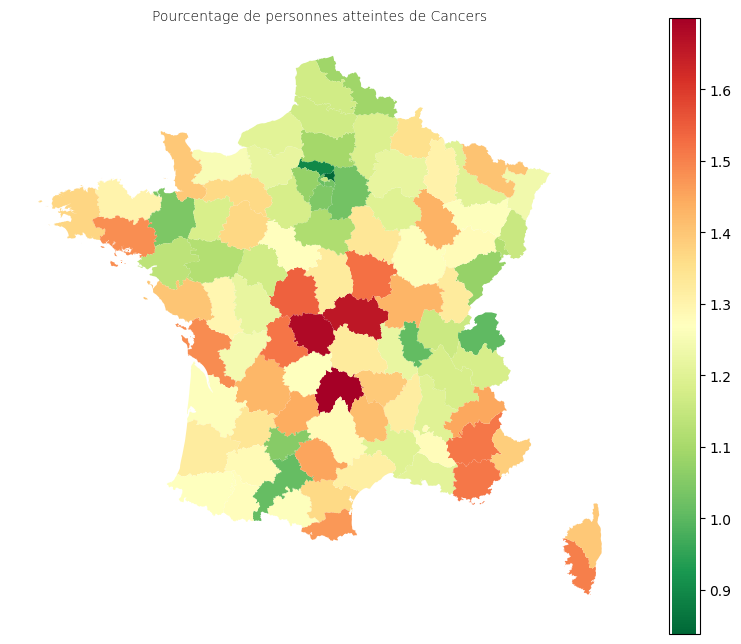

In [25]:
variable_to_plot = "perc"

# Définir les valeurs de coloration
norm = mcolors.Normalize(vmin=merged[variable_to_plot].min(), vmax=merged[variable_to_plot].max())
cmap = plt.colormaps.get_cmap('RdYlGn_r')  # Utilisation de 'RdYlGn_r' pour aller du vert au rouge

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column=variable_to_plot, cmap=cmap, norm=norm, legend=True, ax=ax)

# Supprimer les axes gradués
ax.set_axis_off()

# Ajuster la taille de la barre colorée (legend)
cbar = ax.get_figure().get_axes()[1]
cbar.set_aspect(30)  # Ajuster la taille selon vos besoins

# Ajouter un titre
ax.set_title(f'Pourcentage de personnes atteintes de {disease_to_plot}', fontdict={'fontsize': '10', 'fontweight': '3'})

# Afficher la carte
plt.show()

# Charger les données sur les points de vente de tabac